<a href="https://colab.research.google.com/github/PhiDung-hub/CZ4003/blob/main/Spatial_Pyramid_Matching_CZ4003_Optional_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spatial Pyramid Matching
---
This note book attempt to replicates SPM method from [Lazebnik et al. 2006](http://www.di.ens.fr/willow/pdfs/cvpr06b.pdf). For an excellent survey of pre-deep-learning feature encoding methods for bag of words models, see [Chatfield et al, 2011](http://www.robots.ox.ac.uk/~vgg/research/encoding_eval/).

## Implementation specs
--- 
Procedure are replicated as in the original paper. Hyper-parameter are:      
- $L=0,\ 2 \ ||\ M=200$
- SIFT descriptor and K-means clustering for feature extractions, use a subset of 100 features (SIFT desc) from each image.
- SVM for image classification task

## Dataset
---
[Caltech101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/): Pictures of objects belonging to 101 categories. About 40 to 800 images per category. Most categories have about 50 images. Collected in September 2003 by Fei-Fei Li, Marco Andreetto, and Marc 'Aurelio Ranzato.  The size of each image is roughly 300 x 200 pixels.


### *GUIDE FOR RUNNING THE NOTEBOOK: <br/>*
Download Caltech101 dataset then run on local preferred environment (anaconda, etc.) or connecting collab to your local backend (Instruction provided on the right "Connected" tab)

# Data Loading 
Load Caltech101 data and split them into train/test set according to the original paper specification: 

- train on 30 image per class and test on the rest 
- limit number of test image to 50
- All data are loaded grayscale

**Remember to remove "GOOGLE_background" folder as this will add noise to the dataset.**

In [75]:
import sys
import glob
import joblib 
# !{sys.executable} -m pip install opencv-python
import cv2
import numpy as np
import matplotlib.pyplot as plt

WARNING: Since the data set is large (6K images), better to connect to local runtime

In [ ]:
# Comment out this cell to connect to your Drive folder
# from google.colab import drive

# drive.mount('/content/gdrive')

In [76]:
DATA_DIR = "Dropbox/data/101_ObjectCategories/"
_ = len(DATA_DIR) # dummy string in class name.
class_names = [name[_:] for name in glob.glob(f'{DATA_DIR}*')]
class_names = dict(zip(range(0,len(class_names)), class_names))
print(f'0: {class_names[0]}; 5: {class_names[5]}; 10: {class_names[10]}')
print(f'Number of class: {len(class_names)}')

0: accordion; 5: bass; 10: brontosaurus
Number of class: 101


In [78]:
import sklearn
def load_dataset(path, train_size=30, max_test_size=50):
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []
    for id, class_name in class_names.items():
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        # get train_data
        train_path_class = img_path_class[:train_size]
        train_labels.extend([id]*len(train_path_class))
        for filename in train_path_class:
            train_data.append(cv2.imread(filename, cv2.IMREAD_GRAYSCALE))
        
        if train_size + max_test_size > len(img_path_class): 
            test_path_class = img_path_class[train_size:]
        else:
            test_path_class = img_path_class[train_size:train_size+max_test_size]
        test_labels.extend([id]*len(test_path_class))
        for filename in test_path_class:
            test_data.append(cv2.imread(filename, cv2.IMREAD_GRAYSCALE))

    return train_data, np.array(train_labels), test_data, np.array(test_labels)

# load the dataset
train_data, train_labels, test_data, test_labels = load_dataset(DATA_DIR)
# shuffle data to make classes orderless.
train_data, train_labels = sklearn.utils.shuffle(train_data, train_labels, random_state=0)
test_data, test_labels = sklearn.utils.shuffle(test_data, test_labels, random_state=0)
train_num = len(train_labels); test_num = len(test_labels)
print(f'Number of image \t train: {train_num} \t test: {test_num}')

Number of image 	 train: 3030 	 test: 2945


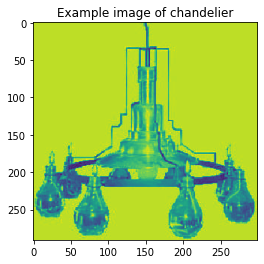

In [79]:
plt.imshow(train_data[0]);
plt.title(f"Example image of {class_names[train_labels[0]]}"); 

# Preprocessing data to obtains "visual vocabulary" representation
Visual vocabs are clustered Scal Invariant Feature Transform (SIFT) descriptors of the entire dataset. In the original paper, 2 type of features are introduced for experimenting. 
- ***Weak feature***: 
Obtained by examining oriented edge points, whose gradient magnitude in a given direction exceed a minimum threshold. 
Author used 2 scales and 8 orientations $\rightarrow$ $M=16$ features and these can be seen as a global SIFT descriptor of the image. 
- ***Strong feature***: 
Obtained by computing $SIFT\ descriptors$ of $16 \times 16$ patches over a grid with $8$ pixels spacing. Afterwards, $K-means\ clustering$ are performed on a subset *(here we use 100 for each image)* of random patches to form the set of visual vocabulary. Typical size are $M=200,\ M=400$.
<br/>

**In this implementation, only strong features with $M=200$ are being tested**


### 1. Feature extraction

In [80]:
def extract_denseSIFT(img, SIFT_SIZE = 16, STEP_SIZE = 8):
    """
    This function compute dense SIFT descriptors of an image. 
    PATCH_SIZE = 16 and STEP_SIZE = 8 are selected as in original paper. 
    """
    SIFTer = cv2.SIFT_create(nfeatures=0, nOctaveLayers=3, contrastThreshold=0.09) # original values in D.Lower paper
    H, W = img.shape    # height and width of the image
    
    # Make sure this is center padding, skip the corner-most patches.
    (y_start, y_end) = (H % STEP_SIZE)//2, H - (H % STEP_SIZE)//2 
    (x_start, x_end) = (W % STEP_SIZE)//2, W - (W % STEP_SIZE)//2

    keypoints = [cv2.KeyPoint(x, y, SIFT_SIZE) for y in range(y_start, y_end+1, STEP_SIZE) for x in range(x_start, x_end+1, STEP_SIZE)]
    descriptors = SIFTer.compute(img, keypoints)[1]
    
    return np.array(descriptors)

desc = extract_denseSIFT(train_data[0])
print(f"No of SIFT descriptor: {desc.shape[0]}\t SIFT vector size: {desc.shape[1]}")

No of SIFT descriptor: 1406	 SIFT vector size: 128


In [ ]:
def extract_sparseSIFT(img):
    """
    This function compute sparse global SIFT descriptors of an image. 
     
    """
    SIFTer = cv2.SIFT_create(nfeatures=0, nOctaveLayers=3, contrastThreshold=0.09) # original values in D.Lower paper
    H, W = img.shape    # height and width of the image
    (y_start, y_end) = (H % STEP_SIZE)//2, H - (H % STEP_SIZE)//2 
    (x_start, x_end) = (W % STEP_SIZE)//2, W - (W % STEP_SIZE)//2

    keypoints = [cv2.KeyPoint(x, y, SIFT_SIZE) for y in range(y_start, y_end+1, STEP_SIZE) for x in range(x_start, x_end+1, STEP_SIZE)]
    descriptors = SIFTer.compute(img, keypoints)[1]
    
    return np.array(descriptors)

desc = extract_sparseSIFT(train_data[0])
print(f"No of SIFT descriptor: {desc.shape[0]}\t SIFT vector size: {desc.shape[1]}")

In [81]:
# THIS RUN QUITE LONG SO COMMENT OUT THE CELL TO RUN ONLY WHEN THE DATASET CHANGE.
import random
def get_all_SIFT_desc(dataset):
    """
    This function get all SIFT descriptors from an entire image data set. Since the size of dataset is large (3060 train images), 
    only 100 random SIFT descriptors from each image is selected this is the same methods as in original paper (though they didn't specify number).
    SIFT descriptors are then being used to calculated the Visual vocabulary. 
    """
    all_SIFT_desc = []
    for i in range(len(dataset)):
        SIFT_desc = extract_denseSIFT(dataset[i])
        rand_idx = np.random.choice(SIFT_desc.shape[0], 100, replace=False) 
        for feature in SIFT_desc[rand_idx]: # select 100 random vector from 
            all_SIFT_desc.extend(feature)

    all_SIFT_desc = np.array(all_SIFT_desc)         # avoid nested call in numpy
    all_SIFT_desc = all_SIFT_desc.reshape(-1, 128)  # SIFT vector is 128 dimensional
    return all_SIFT_desc

# COMMENT THIS OUT TO RUN ONLY ONCE TO AVOID OUT OF MEMORY 
# all_train_desc = get_all_SIFT_desc(train_data)
# joblib.dump(all_train_desc, "Dropbox/all_train_desc.sav")

all_train_desc = joblib.load("Dropbox/all_train_desc.sav")
all_train_desc.shape

(303000, 128)

## 2. Build the visual vocabulary

In [83]:
from sklearn.cluster import KMeans
# build BoW presentation from SIFT of training images, training will take long time
def get_vocab(all_train_desc, vocab_size=200):
    """
    Build vocabulary from set of selected SIFT descriptors
    @output: A K-means classifier can later be used to predict BoW representation of an image
    """
    kmeans = KMeans(n_clusters=vocab_size, random_state=0).fit(all_train_desc)
    return kmeans

# COMMENT THIS OUT TO RUN ONLY ONCE WHENEVER SIFT DESCRIPTORS CHANGE
# visual_vocab = get_vocab(all_train_desc)
# joblib.dump(visual_vocab, "Dropbox/visual_vocab.sav")

visual_vocab = joblib.load("Dropbox/visual_vocab.sav")

## 3. Get data in visual_vocab representation

In [131]:
def get_img_kernel(img, visual_vocab, pyramid_level=2, single_level=False):
    """
    Function to calculate the BoW representation of an image at all levels.

    @params: 
    + img, visual_vocab, pyramid_level = input image, visual vocabulary obtained, depth of pyramid.
    + single_level: if True calculate kernel only at 'pyramid_level' depth. Since histogram is normalize,
    don't need to reset the weight when this mode is turn on.

    @output: A sparse kernel of large dimension, each indicate level of match with a vocabulary (features)
    """
    H, W = img.shape   
    hist = []
    # Iterate through all level to get 
    for L in range(pyramid_level+1):
        if single_level and L != pyramid_level: # if sing_level
            continue
        
        w_step, h_step = W // (2**L), H // (2**L)
        x, y = 0, 0
        # Scan along each level
        for _ in range(2**L):
            x = 0
            for _ in range(2**L):                
                desc = extract_denseSIFT(img[y:y+h_step, x:x+w_step])                     # get SIFT features for this image                             
                intersection = visual_vocab.predict(desc)                                 # get BoW distribution of this sub-region    
                L_hist = np.bincount(intersection, minlength=visual_vocab.n_clusters)     # calculate the histogram
                if L==0:                                                
                    L_hist = L_hist * (2 ** (-pyramid_level))       # make sure weight is given correctly
                else: 
                    L_hist = L_hist * (2 ** (L+1-pyramid_level))    # make sure weight is given correctly
                hist.extend(L_hist)     # append to the "long" vector, later be used for classification
                
                x += w_step     # move to the next sub-region
            y += h_step         # move to the next sub-region
        
    hist = np.array(hist)
    # In the paper, histogram are normalized by total sum of weights
    hist = hist / np.sum(hist)
    
    return hist

x = get_img_kernel(train_data[0], visual_vocab)
print(f"All level (L=2): \nOutput dimension: {x.shape[0]}\t expected: {200*(4**3-1)//3}")
print(f"Non-zero entries: {x[x!=0].size}\t zero entries: {x[x==0].size}")

x = get_img_kernel(train_data[0], visual_vocab, single_level=True)
print(f"Single level (L=2): \nOutput dimension: {x.shape[0]}\t expected: {200*4**2}")
print(f"Non-zero entries: {x[x!=0].size}\t zero entries: {x[x==0].size}")

All level (L=2): 
Output dimension: 4200	 expected: 4200
Non-zero entries: 520	 zero entries: 3680
Single level (L=2): 
Output dimension: 3200	 expected: 3200
Non-zero entries: 288	 zero entries: 2912


In [ ]:
from scipy.sparse import csr_matrix     # Utilize matrix sparseness

def get_data_representation(data, visual_vocab, pyramid_level=2, single_level=False):
    """
    This function build pyramid kernel representation for all dataset
    """    
    data_hist = [get_img_kernel(sample, visual_vocab, pyramid_level, single_level) for sample in data]
    return np.array(data_hist)

def proces_data(pyramid_level=2, save_path='Dropbox/'):
    """
    This function calculate data pyramid kernel representation both pyramid 
    and single level (if applicable). Then save them in form of sparse matrix. 
    @output: array of file paths of train_data and test_data both pyramid and single level
    """
    assert(pyramid_level>=0)
    
    train_hist = get_data_representation(train_data, visual_vocab, pyramid_level)
    train_sparse = csr_matrix(train_hist)
    joblib.dump(train_sparse, f"{save_path}train_{pyramid_level}.sav")
    del train_hist, train_sparse

    test_hist = get_data_representation(test_data, visual_vocab, pyramid_level)
    test_sparse = csr_matrix(test_hist)
    joblib.dump(test_sparse, f"{save_path}test_{pyramid_level}.sav")
    del test_hist, test_sparse

    if pyramid_level > 0:
        train_hist_single = get_data_representation(train_data, visual_vocab, pyramid_level, True)
        train_sparse_single = csr_matrix(train_hist_single)
        joblib.dump(train_sparse_single, f"{save_path}train_single_{pyramid_level}.sav")
        del train_hist_single, train_sparse_single

        test_hist_single = get_data_representation(test_data, visual_vocab, pyramid_level, True)
        test_sparse_single = csr_matrix(test_hist_single)
        joblib.dump(test_sparse_single, f"{save_path}test_single_{pyramid_level}.sav")
        del test_hist_single, test_sparse_single



Indeed output vectors are very sparse as described in the original paper.

# Training and prediction result
Follow experimental setting from table 2 in the original paper, there are 5 case being tested:

 1. Pyramid with 0 level (original Bag of Words algorithm)
 2. 1-level depth pyramid: *single level (dim=800)* vs. *all level kernel (dim=100)*
 3. 2-level depth pyramid: *single level (dim=3200)* vs. *all level kernel (dim=4200)* 
<br/>
 ***All hyper-parameters for Linear SVM Classifier have been selected through trial and error. Though through much effort, it is not guaranteed the best has been found.***

In [122]:
from sklearn.svm import LinearSVC       # Classifier object being used

def train_and_predict(SVC, train_hist, test_hist):
    """
    This function train and predict data after converted into pyramid kernel representation.
    @output: SVM Classifier after trained and its prediction on test set
    """
    SVC.fit(train_hist, train_labels)
    predictions = SVC.predict(test_hist)
    print(f"Accuracy:  {np.mean(predictions == test_labels)*100}%")

    return SVC, predictions

def get_intra_class_accuracy(predictions, labels):
    """
    This function calculate predictions accuracy for all classes. Since class are labels [0...100]
    and class names can be access via global variable "class_names". Accuracy is store in form of 
    an array size 101. arr[i] is predictions accuracy for class (i+1)th.
    """
    class_accuracy = [0 * len(labels)]
    class_count = [0*len(labels)]
    # count number of class representative and number of correct prediction.
    for i in range(len(labels)):
        class_accuracy[labels[i]] += (predicttions[i] == labels[i])
        class_count[labels[i]] += 1
    # get accuracy for each class
    for i in range(len(lables)):
        class_accuracy[i] /= class_count[i]

    return class_accuracy

### 0-level pyramid (traditional BoW classification)


In [98]:
train_hist_0 = joblib.load("Dropbox/train_hist_0.sav")
test_hist_0 = joblib.load("Dropbox/test_hist_0.sav")

In [154]:
SVC = LinearSVC(dual=False, C=25, tol=1e-4, 
                max_iter=5000, random_state=0)

print(f"L = 0\t Vector dimension = {train_hist_0.shape[1]}")
clf_0, pred_0 = train_and_predict(SVC, train_hist_0, test_hist_0)

L = 0	 Vector dimension = 200
Accuracy:  43.12393887945671%


### 1-level Pyramid

All Level

In [158]:
train_hist_1 = joblib.load("Dropbox/train_hist_1.sav")
test_hist_1 = joblib.load("Dropbox/test_hist_1.sav")

SVC = LinearSVC(dual=False, C=70, tol=1e-6, 
                max_iter=5000, random_state=0)

print(f"L = 1\t Vector dimension = {train_hist_1.shape[1]}")
clf_1, pred_1 = train_and_predict(SVC, train_hist_1, test_hist_1)

L = 1	 Vector dimension = 1000
Accuracy:  51.13752122241087%


Single level

In [162]:
train_hist_1_single = joblib.load("Dropbox/train_hist_1_single.sav")
test_hist_1_single = joblib.load("Dropbox/test_hist_1_single.sav")

SVC = LinearSVC(dual=False, C=70, tol=1e-6, 
                max_iter=2000, random_state=0)
print(f"L = 1\t Vector dimension = {train_hist_1_single.shape[1]}")
clf_1_single, pred_1_single = train_and_predict(SVC, train_hist_1_single, test_hist_1_single)

L = 1	 Vector dimension = 800
Accuracy:  49.9490662139219%


### 2-level pyramid

All-level

In [172]:
train_hist_2 = joblib.load("Dropbox/train_hist_2.sav")
test_hist_2 = joblib.load("Dropbox/test_hist_2.sav")

SVC = LinearSVC(dual=True, loss='hinge', C=700, tol=1e-6, 
                max_iter=10000, random_state=0)
print(f"L = 2\t Vector dimension = {train_hist_2.shape[1]}")
clf_2, pred_2 = train_and_predict(SVC, train_hist_2, test_hist_2)

L = 2	 Vector dimension = 4200
Accuracy:  55.75551782682513%


C:\Users\Phi\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Single level

In [175]:
train_hist_2_single = joblib.load("Dropbox/train_hist_2_single.sav")
test_hist_2_single = joblib.load("Dropbox/test_hist_2_single.sav")

SVC = LinearSVC(dual=False, C=70, tol=1e-6, 
                max_iter=10000, random_state=0)
print(f"L = 2\t Vector dimension = {train_hist_2_single.shape[1]}")
clf_2_single, pred_2_single = train_and_predict(SVC, train_hist_2_single, test_hist_2_single)

L = 2	 Vector dimension = 3200
Accuracy:  52.359932088285234%


In [ ]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler(copy=False)

train_sparse = csr_matrix(train_hist_2)
test_sparse = csr_matrix(test_hist_2)
train_scaled = scaler.fit_transform(train_sparse)
test_scaled = scaler.fit_transform(test_sparse)

clf_, pred_ = train_and_predict(SVC, train_scaled, test_scaled)

### NOTE ON IMPROVEMENT:

+ Due to time constraint, efficient data stream ([tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)) has not yet been implemented

+ Parallelization can be implemented ([joblib](https://joblib.readthedocs.io/en/latest/generated/joblib.Parallel.html)) in Pyramid matching kernel function from level 1 onwards, and in global data transformation process (get pyramid kernel)

+ Haven't think of a way to utilize sparseness of pyramid matching kernel vector

In [ ]:
#@title
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(np.array([test_label]).T, y_predict)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(18, 6))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(18, 6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()